## Pense como um Cientista de Dados
### Modelos de Árvore e Otimização Bayesiana para Classificação Binária: Casos Práticos no Mundo dos Negócios

### <font color = 'blue'>Capítulo 5. Explorando e Modelando o Risco de <em>churn</em> com o *Telecom Churn Rate Dataset*</font>
##### fonte: https://www.kaggle.com/datasets/mirzahasnine/telecom-churn-dataset

```{python}
%load_ext watermark
%watermark -v -p numpy,pandas,scikit-learn,xgboost -u -n -t -z

Last updated: Thu Sep 26 2024 19:01:58-03

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.25.0

numpy       : 1.26.4
pandas      : 2.2.2
scikit-learn: 1.4.2
xgboost     : 2.1.1
```

In [1]:
import pandas as pd
import numpy as np
import re
import shap
import matplotlib.pyplot as plt
from typing import Tuple, Any
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from sklearn.metrics import (roc_auc_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, roc_curve, auc, precision_recall_curve)
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from scipy.sparse import csr_matrix

In [2]:
SEED = 42

In [3]:
# Caminho do arquivo
file_path = 'archive/Telecom Churn Rate Dataset.xlsx'

# Ler o arquivo .xlsx
df = pd.read_excel(file_path)

# Exibir as primeiras linhas do dataframe
df.head()

,Gender,Senior_Citizen,Partner,Dependents,Tenure,Phone_Service,Multiple_Lines,Internet_Service,Online_Security,Online_Backup,...,Streaming_TV,Streaming_Movies,Contract,Paper_less_Billing,Payment_Method,Monthly_Charges,Yearly_Charge,Admin_Tickets,Tech_Tickets,Churn
0,Male,Yes,No,No,1,No,No phone service,DSL,No,No,...,No,Yes,Month-to-month,Yes,Electronic check,396.5,4758,0,0,Yes
1,Female,Yes,Yes,No,71,Yes,Yes,Fiber optic,Yes,Yes,...,No,No,Two year,Yes,Credit card (automatic),963.5,11562,0,0,No
2,Male,Yes,Yes,No,2,Yes,No,Fiber optic,No,No,...,Yes,Yes,Month-to-month,Yes,Credit card (automatic),955.0,11460,0,0,No
3,Male,Yes,No,No,1,Yes,No,DSL,No,No,...,No,No,Month-to-month,No,Bank transfer (automatic),452.5,5430,0,0,No
4,Female,Yes,No,No,43,Yes,Yes,Fiber optic,No,Yes,...,Yes,No,Month-to-month,Yes,Electronic check,902.5,10830,0,0,No


In [4]:
df.shape

(1142, 22)

In [5]:
df.isna().sum()

Gender                0
Senior_Citizen        0
Partner               0
Dependents            0
Tenure                0
Phone_Service         0
Multiple_Lines        0
Internet_Service      0
Online_Security       0
Online_Backup         0
Device_Protection     0
Tech_Support          0
Streaming_TV          0
Streaming_Movies      0
Contract              0
Paper_less_Billing    0
Payment_Method        0
Monthly_Charges       0
Yearly_Charge         0
Admin_Tickets         0
Tech_Tickets          0
Churn                 0
dtype: int64

In [6]:
# Verificar a distribuição da variável alvo
df['Churn'].value_counts(normalize=True)

Churn
No     0.583187
Yes    0.416813
Name: proportion, dtype: float64

In [7]:
# Função para verificar se há valores não numéricos em cada coluna
def verificar_valores_nao_numericos(df):
    for column in df.columns:
        # Tentar converter o valor para float; se falhar, é um valor não numérico
        non_numeric_values = df[column].apply(lambda x: bool(re.search(r'[^\d.-]', str(x))) if pd.notnull(x) else False)

        # Se houver algum valor não numérico, exibir a coluna e os valores
        if non_numeric_values.any():
            print(f"Coluna '{column}' contém valores não numéricos:")
            print(df[column][non_numeric_values].unique())

# Chamar a função para o DataFrame
verificar_valores_nao_numericos(df)

Coluna 'Gender' contém valores não numéricos:
['Male' 'Female']
Coluna 'Senior_Citizen' contém valores não numéricos:
['Yes']
Coluna 'Partner' contém valores não numéricos:
['No' 'Yes']
Coluna 'Dependents' contém valores não numéricos:
['No' 'Yes']
Coluna 'Phone_Service' contém valores não numéricos:
['No' 'Yes']
Coluna 'Multiple_Lines' contém valores não numéricos:
['No phone service' 'Yes' 'No']
Coluna 'Internet_Service' contém valores não numéricos:
['DSL' 'Fiber optic' 'No']
Coluna 'Online_Security' contém valores não numéricos:
['No' 'Yes' 'No internet service']
Coluna 'Online_Backup' contém valores não numéricos:
['No' 'Yes' 'No internet service']
Coluna 'Device_Protection' contém valores não numéricos:
['Yes' 'No' 'No internet service']
Coluna 'Tech_Support' contém valores não numéricos:
['No' 'Yes' 'No internet service']
Coluna 'Streaming_TV' contém valores não numéricos:
['No' 'Yes' 'No internet service']
Coluna 'Streaming_Movies' contém valores não numéricos:
['Yes' 'No' 'No 

Vamos passar por um processo passo a passo para tratar o dataset de Telecom Churn visando a preparação dos dados para um modelo de machine learning. O objetivo é garantir que todas as variáveis estejam no formato correto e que informações categóricas sejam devidamente transformadas em numéricas, além de lidar com possíveis valores faltantes ou inconsistências.

1. Exploração inicial dos dados
Antes de qualquer coisa, precisamos fazer uma análise exploratória inicial para entender as características do dataset, suas variáveis, valores faltantes e tipos de dados. Já foi identificado que algumas colunas têm valores categóricos que precisam ser convertidos.

2. Conversão de Variáveis Categóricas para Numéricas
Algumas colunas têm valores que são representações textuais de categorias, como 'Gender' com valores 'Male' e 'Female', ou 'Churn' com 'Yes' e 'No'. Precisamos converter essas variáveis categóricas para numéricas, pois algoritmos de machine learning geralmente esperam entradas numéricas.

Etapa de conversão:
Colunas binárias (Sim/Não ou Male/Female): Podem ser diretamente convertidas em 0 e 1. Usaremos o método map() para essa tarefa.

In [8]:
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
df['Senior_Citizen'] = df['Senior_Citizen'].map({'Yes': 1, 'No': 0})
df['Partner'] = df['Partner'].map({'Yes': 1, 'No': 0})
df['Dependents'] = df['Dependents'].map({'Yes': 1, 'No': 0})
df['Phone_Service'] = df['Phone_Service'].map({'Yes': 1, 'No': 0})
df['Paper_less_Billing'] = df['Paper_less_Billing'].map({'Yes': 1, 'No': 0})
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

Explicação:
Mapeamento binário: Essa técnica mapeia valores categóricos binários diretamente para 0 e 1. Isso é útil porque facilita a entrada nos algoritmos de machine learning, especialmente para classificações.
3. Tratar Colunas com Múltiplas Categorias
Algumas colunas, como Contract, Internet_Service, e Payment_Method, têm várias categorias (mais de dois valores distintos). Para essas variáveis, usaremos One-Hot Encoding para transformar as categorias em colunas binárias. Isso é feito com o OneHotEncoder do Scikit-learn ou o método get_dummies() do Pandas.

In [9]:
df = pd.get_dummies(df, columns=['Internet_Service', 'Contract', 'Payment_Method', 'Multiple_Lines',
                                 'Online_Security', 'Online_Backup', 'Device_Protection', 'Tech_Support',
                                 'Streaming_TV', 'Streaming_Movies'], drop_first=True)

Tratar possíveis valores especiais: Como discutido anteriormente, certifique-se de que os valores especiais como 'No phone service' ou 'No internet service' sejam tratados corretamente.

Confirme a imputação: Verifique se há valores ausentes ou inconsistências e faça as devidas imputações, se necessário.

In [10]:
print(df.isnull().sum())


Gender                                    0
Senior_Citizen                            0
Partner                                   0
Dependents                                0
Tenure                                    0
Phone_Service                             0
Paper_less_Billing                        0
Monthly_Charges                           0
Yearly_Charge                             0
Admin_Tickets                             0
Tech_Tickets                              0
Churn                                     0
Internet_Service_Fiber optic              0
Internet_Service_No                       0
Contract_One year                         0
Contract_Two year                         0
Payment_Method_Credit card (automatic)    0
Payment_Method_Electronic check           0
Payment_Method_Mailed check               0
Multiple_Lines_No phone service           0
Multiple_Lines_Yes                        0
Online_Security_No internet service       0
Online_Security_Yes             

In [11]:
df.shape

(1142, 33)

Sim, há um jeito mais eficiente de converter várias colunas com valores booleanos (True/False) para 1/0 de forma rápida. Em vez de fazer isso manualmente para cada coluna, você pode aplicar uma única linha de código para todas as colunas com valores booleanos de uma só vez.

Aqui está um exemplo usando o método .astype(int) em todas as colunas booleanas de uma vez:

Passo a passo:
Identificar colunas booleanas automaticamente: O Pandas permite selecionar todas as colunas booleanas usando .select_dtypes(), e então podemos aplicar .astype(int) para convertê-las de True/False para 1/0.


In [12]:
# Converter todas as colunas booleanas (True/False) para 1/0 de uma vez
df[df.select_dtypes(include=['bool']).columns] = df.select_dtypes(include=['bool']).astype(int)


Explicação do código:
select_dtypes(include=['bool']): Seleciona todas as colunas do DataFrame que têm o tipo de dado booleano (True/False).
astype(int): Converte os valores True para 1 e False para 0 em todas as colunas booleanas.
Dessa forma, você não precisa converter manualmente cada coluna, e o código será executado de forma eficiente para todas as colunas booleanas.

In [13]:
df

,Gender,Senior_Citizen,Partner,Dependents,Tenure,Phone_Service,Paper_less_Billing,Monthly_Charges,Yearly_Charge,Admin_Tickets,...,Online_Backup_No internet service,Online_Backup_Yes,Device_Protection_No internet service,Device_Protection_Yes,Tech_Support_No internet service,Tech_Support_Yes,Streaming_TV_No internet service,Streaming_TV_Yes,Streaming_Movies_No internet service,Streaming_Movies_Yes
0,0,1,0,0,1,0,1,396.5,4758,0,...,0,0,0,1,0,0,0,0,0,1
1,1,1,1,0,71,1,1,963.5,11562,0,...,0,1,0,1,0,1,0,0,0,0
2,0,1,1,0,2,1,1,955.0,11460,0,...,0,0,0,1,0,0,0,1,0,1
3,0,1,0,0,1,1,0,452.5,5430,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,43,1,1,902.5,10830,0,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1137,1,1,1,0,63,1,1,1035.0,12420,0,...,0,1,0,1,0,0,0,1,0,1
1138,1,1,0,0,6,0,1,444.0,5328,0,...,0,0,0,0,0,0,0,1,0,1
1139,0,1,1,0,55,1,0,600.0,7200,0,...,0,1,0,0,0,0,0,0,0,0
1140,0,1,0,0,1,1,1,757.5,9090,0,...,0,0,0,0,0,0,0,0,0,0


Normalizar colunas numéricas: As colunas que representam valores contínuos como 'Monthly_Charges', 'Yearly_Charge', e 'Tech_Tickets' podem ser normalizadas para garantir que estejam na mesma escala, o que é especialmente útil para algoritmos que são sensíveis a escalas.

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['Monthly_Charges', 'Yearly_Charge', 'Admin_Tickets', 'Tech_Tickets']] = scaler.fit_transform(df[['Monthly_Charges', 'Yearly_Charge', 'Admin_Tickets', 'Tech_Tickets']])


Separação de treino e teste: Agora que os dados estão tratados, você pode separar os dados em treino e teste para treinar seu modelo de classificação.

In [15]:
from sklearn.model_selection import train_test_split

X = df.drop('Churn', axis=1)  # Variáveis independentes
y = df['Churn']  # Variável dependente

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Explicação do processo:
Substituição de valores categóricos: Substituímos valores como 'Yes', 'No', e 'No internet service' por valores numéricos (0 e 1) para que os modelos de machine learning possam trabalhar com esses dados.

One-Hot Encoding: Para as colunas que têm múltiplas categorias (por exemplo, 'Contract' ou 'Payment_Method'), usamos o One-Hot Encoding para criar variáveis binárias, facilitando a utilização desses dados em algoritmos de machine learning.

Normalização de colunas numéricas: O StandardScaler foi usado para garantir que todas as colunas numéricas estejam na mesma escala, o que evita que uma variável com uma magnitude maior domine o modelo.

Separação dos dados: Finalmente, os dados são separados em conjuntos de treino e teste, onde 70% dos dados são usados para treinar o modelo e 30% para testar sua performance.

Com esses passos, seus dados estarão prontos para serem usados em um modelo de machine learning para prever a taxa de churn.

In [16]:
df['Churn'].value_counts()

Churn
0    666
1    476
Name: count, dtype: int64

In [17]:
# Aplicar SMOTE no conjunto de treino
smote = SMOTE(random_state=SEED)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Verificar a nova distribuição das classes após o SMOTE
print("Distribuição das classes antes do SMOTE:", y_train.value_counts())
print("Distribuição das classes após o SMOTE:", y_train_res.value_counts())

Distribuição das classes antes do SMOTE: Churn
0    463
1    336
Name: count, dtype: int64
Distribuição das classes após o SMOTE: Churn
1    463
0    463
Name: count, dtype: int64


## Sem aplicar SMOTE

In [18]:
X_train_res, y_train_res = X_train, y_train

In [19]:
feature_names = X.columns

In [20]:
# Função para otimizar modelos e calcular o melhor threshold
def find_best_threshold(y_true: np.ndarray, y_scores: np.ndarray, metric: str = 'f1') -> Tuple[float, float]:
    """
    Função para encontrar o melhor threshold para a métrica escolhida (f1, precisão, recall).
    """
    thresholds = np.linspace(0, 1, 101)
    scores = []

    for thresh in thresholds:
        y_pred = (y_scores >= thresh).astype(int)
        if metric == 'f1':
            score = f1_score(y_true, y_pred)
        elif metric == 'precision':
            score = precision_score(y_true, y_pred)
        elif metric == 'recall':
            score = recall_score(y_true, y_pred)
        scores.append(score)

    best_idx = np.argmax(scores)
    return thresholds[best_idx], scores[best_idx]

def optimize_ensemble_models(X_train_res, X_test_scaled, y_train_res, y_test, metric='f1'):
    param_spaces = {
        'random_forest': {
            'n_estimators': (10, 200),
            'max_depth': (None, 5, 10, 20, 30),
            'min_samples_split': (2, 5, 10, 20)
        },
        'adaboost': {
            'n_estimators': (10, 400),
            'learning_rate': (0.01, 1.0)
        },
        'xgboost': {
            'n_estimators': (100, 500),
            'max_depth': (3, 20),
            'learning_rate': (0.01, 0.3),
            'subsample': (0.2, 1.0)
        }
    }

    best_auc = 0
    best_model = None

    models = {
        'random_forest': RandomForestClassifier(random_state=SEED),
        'adaboost': AdaBoostClassifier(algorithm='SAMME', random_state=SEED),
        'xgboost': XGBClassifier(eval_metric='logloss', random_state=SEED)
    }

    for model_name, model in models.items():
        bayes_search = BayesSearchCV(model, param_spaces[model_name], 
                                     n_iter=30, scoring='roc_auc', cv=5, n_jobs=-1, random_state=SEED)
        bayes_search.fit(X_train_res, y_train_res)
        best_params = bayes_search.best_params_

        model.set_params(**best_params)
        model.fit(X_train_res, y_train_res)

        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        auc_score = roc_auc_score(y_test, y_pred_proba)

        print(f"{model_name} AUC: {auc_score:.4f}")

        if auc_score > best_auc:
            best_auc = auc_score
            best_model = model

    print(f"\nMelhor modelo: {type(best_model).__name__} com AUC: {best_auc:.4f}")

    best_threshold, best_metric_score = find_best_threshold(y_test, y_pred_proba, metric=metric)
    y_pred_adjusted = (y_pred_proba >= best_threshold).astype(int)

    precision = precision_score(y_test, y_pred_adjusted)
    recall = recall_score(y_test, y_pred_adjusted)
    f1 = f1_score(y_test, y_pred_adjusted)
    cm = confusion_matrix(y_test, y_pred_adjusted)

    print(f"\nThreshold ótimo ({metric}): {best_threshold:.2f}")
    print("\nMatriz de Confusão Ajustada:")
    print(cm)
    print(f"\nPrecisão: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {auc(fpr, tpr):.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.legend(loc="lower right")
    plt.savefig('images/roc_curve.png')
    plt.show()

    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(recall_curve, precision_curve, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precisão')
    plt.title(f'Curva Precision-Recall')
    plt.savefig('images/precision_curve.png')
    plt.show()

    return best_model, X_test_scaled, y_test

def explain_model(best_model: Any, X_test: np.ndarray, feature_names: list):
    """
    Gera gráficos SHAP para interpretar o modelo treinado.
    """
    X_test_dense = pd.DataFrame(X_test.toarray() if isinstance(X_test, csr_matrix) else X_test, columns=feature_names)
    X_test_dense = X_test_dense.apply(pd.to_numeric, errors='coerce')

    # Reduzir o background usando K-means com 10 clusters (para o Adaboost)
    background_kmeans = shap.kmeans(X_train, 10)  # Usar 10 centróides como background

    if isinstance(best_model, (RandomForestClassifier, XGBClassifier)):
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_test_dense)
        shap_values_class_1 = shap_values[:, :, 1] if isinstance(best_model, RandomForestClassifier) else shap_values
    elif isinstance(best_model, AdaBoostClassifier):
        explainer = shap.KernelExplainer(best_model.predict_proba, background_kmeans)
        shap_values = explainer.shap_values(X_test_dense)
        shap_values_class_1 = shap_values[:, :, 1]
    else:
        raise ValueError(f"Modelo {type(best_model)} não suportado.")

    shap.summary_plot(shap_values_class_1, X_test_dense)
    
    plt.show()

    # Calcular a média dos valores SHAP ao longo de todas as amostras para obter a importância das features
    shap_values_mean = np.mean(shap_values_class_1, axis=0)
    
    # Gerar o gráfico de barras horizontais
    shap.bar_plot(shap_values_mean, feature_names=feature_names, max_display=20)
     
    plt.show()

    # Retornar os valores SHAP para uso posterior
    return shap_values_class_1, X_test_dense  # Aqui é onde garantimos o retorno

In [21]:
feature_names = X.columns

random_forest AUC: 0.8924
adaboost AUC: 0.9026
xgboost AUC: 0.8993

Melhor modelo: AdaBoostClassifier com AUC: 0.9026

Threshold ótimo (f1): 0.20

Matriz de Confusão Ajustada:
[[141  62]
 [  7 133]]

Precisão: 0.6821
Recall: 0.9500
F1-Score: 0.7940


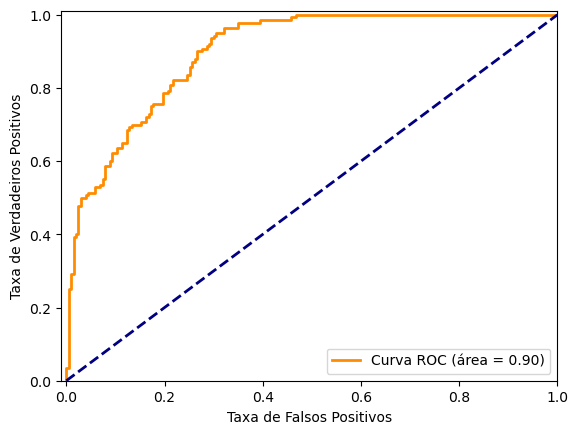

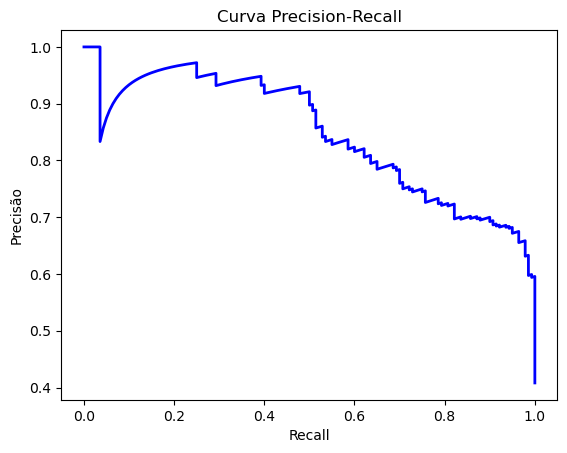

CPU times: user 2min 33s, sys: 3.58 s, total: 2min 37s
Wall time: 1min 6s


In [22]:
%%time
# Otimizar modelos e encontrar o melhor
best_model, X_test, y_test = optimize_ensemble_models(X_train_res, X_test, y_train_res, y_test)

  0%|          | 0/343 [00:00<?, ?it/s]

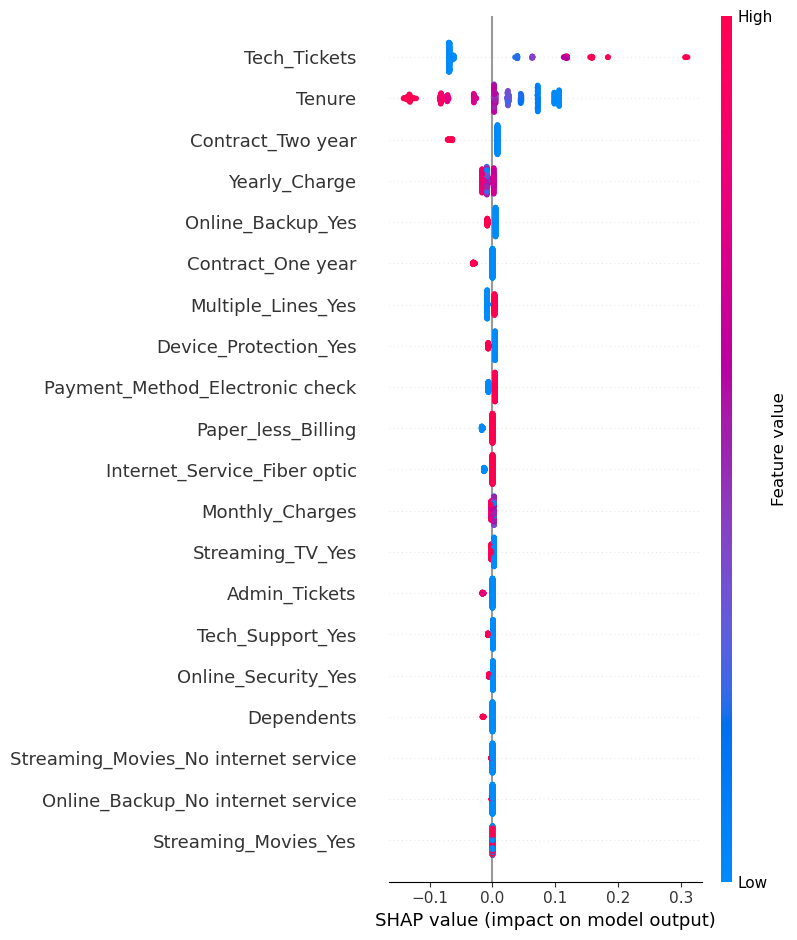

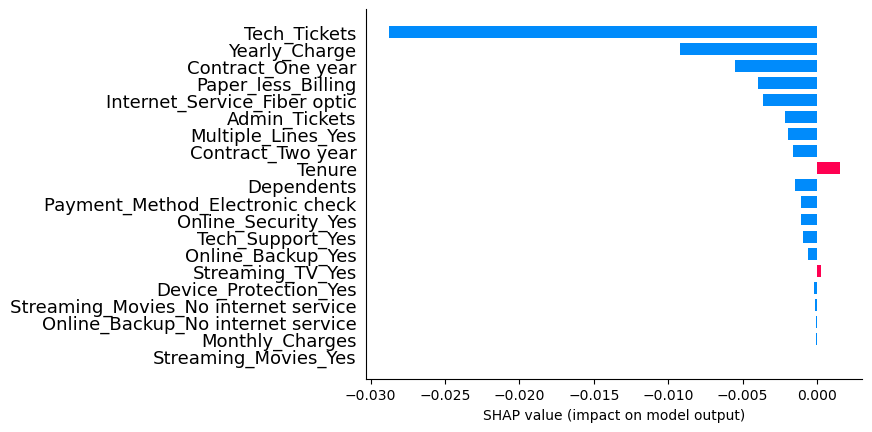

CPU times: user 6min, sys: 3.67 s, total: 6min 4s
Wall time: 2min 36s


In [23]:
%%time
# Interpretabilidade com SHAP
# Chamar a função sem imprimir os retornos
shap_values_class_1, X_test_dense = explain_model(best_model, X_test, feature_names)

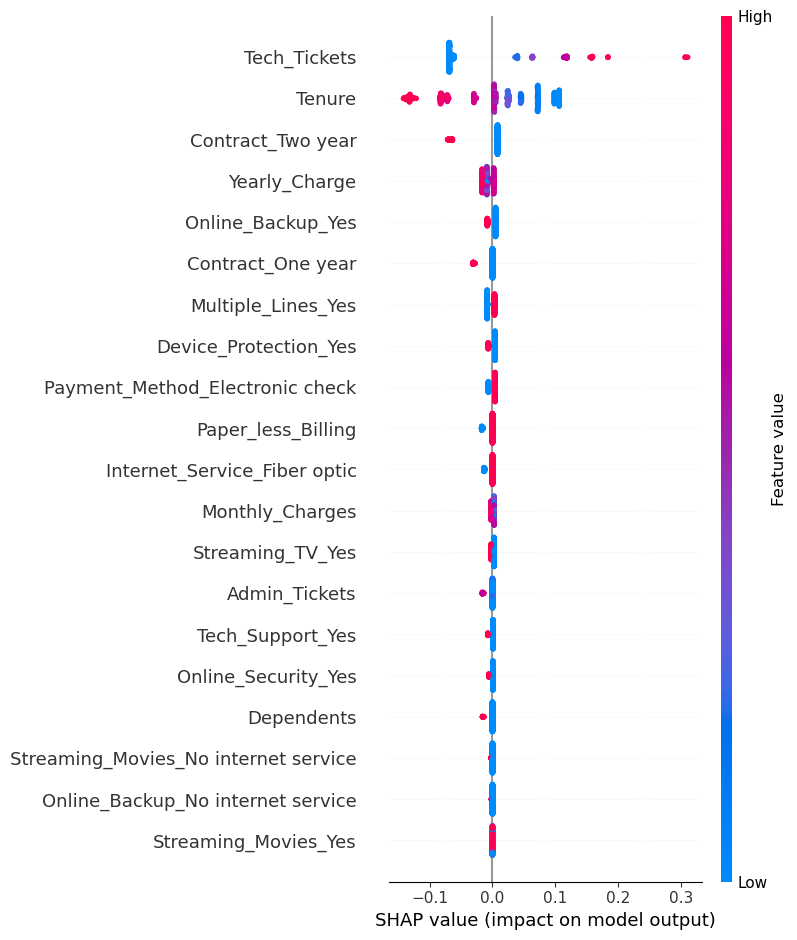

In [24]:
# Gerar o gráfico de dispersão SHAP sem exibir
shap.summary_plot(shap_values_class_1, X_test_dense, show=False)

# Mostrar o gráfico na tela (opcional)
plt.savefig('images/beeswarm_shap.png')
plt.show()

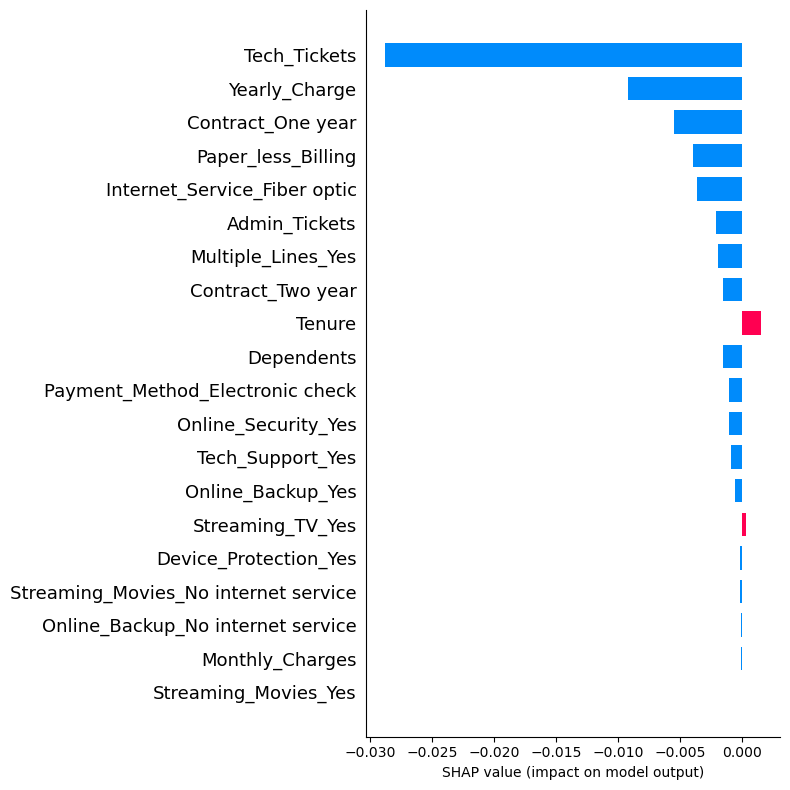

In [25]:
# Gerar o gráfico de barras SHAP sem exibir

# Definir o tamanho da figura (width, height)
plt.figure(figsize=(8, 8))  # Ajuste os valores conforme necessário

# Calcular a média dos valores SHAP ao longo de todas as amostras para obter a importância das features
shap_values_mean = np.mean(shap_values_class_1, axis=0)

shap.bar_plot(shap_values_mean, feature_names=feature_names, max_display=20, show=False)

# Ajustar o layout para evitar que o gráfico fique cortado
plt.tight_layout()

plt.savefig('images/bar_shap.png')
# Mostrar o gráfico na tela (opcional)
plt.show()